<a href="https://colab.research.google.com/github/andres-gomez-alvarez/VRES2024/blob/main/VRES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Simulation Study
Here, we apply our methods to data that are simulated from a logistic regression model that contains
two covariates, x1 and x2. The following logistic model
is used to describe the binary response variable Yi ∼
Binary(πi) where $logit(πi) = θ_0 + θ_1x_(1i) + θ_2x_(2i)$ We
assume that the true parameter values are $(θ_0, θ_1, θ_2) =
(−1, 0.3, 0.1)$ and that the sample size for the full data
set is $N = 10000$. Although N is small for Big Data,
it will serve to illustrate and motivate the essential features of our approach. We simulate the covariate values
of $x_1$ and $x_2$ for each observation from a multivariate
normal distribution with a mean vector of zeros and
three different options for the covariance matrix:

In [ ]:
#packages and loading tidyverse and helper functions
install.packages("gridExtra")
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(MASS)

#gen data
data_gen_logit_2covars=function(N,sigma,Mu,beta){
  set.seed(42)
  samples <- mvrnorm(n = N, mu = Mu, Sigma = sigma)
  x1=samples[,1]
  x2=samples[,2]
  lp=beta[1]+beta[2]*x1+beta[3]*x2
  p=1/(1+exp(-lp))
  y=as.numeric(p>runif(N))
  X=cbind(rep(1,N),x1,x2)
  df=data.frame(y,x1,x2,lp,p)
  outputs=list(X,df)
  return(outputs)
}
#Expected info matrix
Fisher_logitreg=function(X,estimate){
  lp=estimate[1]*X[,1]+estimate[2]*X[,2]+estimate[3]*X[,3]
  p=1/(1+exp(-lp))
  wi <- p*(1-p)
  W <- diag(wi)
  t(X) %>% dim() %>% print()
  t(t(W)) %>% dim() %>% print()
  X %>% dim() %>% print()
  t(X)%*%W %>% dim() %>% print()
  return(t(X)%*%W%*%X)
}
Information_mat_one_point <- function(estimate, X) {
  lp <- estimate[1] + estimate[2] * X[, 1] + estimate[3] * X[, 2]
  p <- 1 / (1 + exp(-lp))

  # Vectorized computation of sums
  sum_p_1_minus_p <- sum(p * (1 - p))
  sum_p_1_minus_p_X1 <- sum(p * (1 - p) * X[, 1])
  sum_p_1_minus_p_X2 <- sum(p * (1 - p) * X[, 2])

  sum_p_1_minus_p_X1_squared <- sum(p * (1 - p) * X[, 1]^2)
  sum_p_1_minus_p_X2_X1 <- sum(p * (1 - p) * X[, 2] * X[, 1])
  sum_p_1_minus_p_X2_squared <- sum(p * (1 - p) * X[, 2]^2)

  # Create the information matrix
  Information_mat <- matrix(c(
    sum_p_1_minus_p, sum_p_1_minus_p_X1, sum_p_1_minus_p_X2,
    sum_p_1_minus_p_X1, sum_p_1_minus_p_X1_squared, sum_p_1_minus_p_X2_X1,
    sum_p_1_minus_p_X2, sum_p_1_minus_p_X2_X1, sum_p_1_minus_p_X2_squared
  ), nrow = 3, ncol = 3)

  return(Information_mat)
}

#Information_mat_one_point=function(estimate,X){
  #lp=estimate[1]+estimate[2]*X[,1]+estimate[3]*X[,2]
  #p=p=1/(1+exp(-lp))
  #Information_mat<- matrix(c(sum(p*(1-p)),sum(p*(1-p)*X[,1]),sum(p*(1-p)*X[,2]),
  #sum(p*(1-p)*X[,1]),sum(p*(1-p)*X[,1]^2),sum(p*(1-p)*X[,2]*X[,1]),
  #sum(p*(1-p)*X[,2]),sum(p*(1-p)*X[,2]*X[,1]),sum(p*(1-p)*X[,2]^2)), nrow = 3, ncol = 3)
 # return(Information_mat)
#}

#sampling the initial Ds
Sampling=function(size,seed,data_frame,Z){
  set.seed(seed)
  #sample numbers
  sampled_indices <- sample(nrow(data_frame), size, replace = FALSE)
  #sample df
  sampled_rows <- data_frame[sampled_indices, ]
  #sample design Matrix
  X_0=Z[sampled_indices,]
  #update the matrix and df without the sampled data
  Z=Z[-sampled_indices,]
  data_frame= data_frame[-sampled_indices, ]
  outputs=list(sampled_rows,data_frame,Z,X_0)
  return(outputs)
}
#grid information matrix computation
List_Infor_Matrices <- function(grid, beta_hat) {
  a_list <- lapply(1:nrow(grid), function(i) Information_mat_one_point(beta_hat, grid[i,]))
  return(a_list)
}

#List_Infor_Matrices=function(grid,beta_hat){
 # a_list=vector(mode='list', length=nrow(grid))
  #for(i in 1:nrow(grid)){a_list[[i]]=Information_mat_one_point(beta_hat,grid[i,])}
  #return(a_list)
#}

#utility function computation
Utility_func <- function(list_of_matrices,special_matrix){

# Function to calculate determinant after adding the special matrix
    calculate_determinant <- function(matrix_idx) {
  # Add the special matrix to the matrix in the list
      modified_matrix <- list_of_matrices[[matrix_idx]] + special_matrix

  # Calculate the determinant
      determinant <- det(modified_matrix)

  # Return the determinant
      return(determinant)
    }

# Apply the function to each matrix in the list
  determinant_results <- sapply(seq_along(list_of_matrices), calculate_determinant)

# Find the index and value of the determinant with the highest numerical value
  max_determinant_index <- which.max(determinant_results)
  max_determinant_value <- determinant_results[max_determinant_index]
  #results=c(max_determinant_index,max_determinant_value)

  return(max_determinant_index)
  #return(determinant_results)
}
#Almost identical but this is for top performers analysis
Utility_func_list <- function(list_of_matrices,special_matrix){

# Function to calculate determinant after adding the special matrix
    calculate_determinant <- function(matrix_idx) {
  # Add the special matrix to the matrix in the list
      modified_matrix <- list_of_matrices[[matrix_idx]] + special_matrix

  # Calculate the determinant
      determinant <- det(modified_matrix)

  # Return the determinant
      return(determinant)
    }

# Apply the function to each matrix in the list
  determinant_results <- sapply(seq_along(list_of_matrices), calculate_determinant)

  return(determinant_results)
}
# Function to get top n minimum distances and remove them from the original data frame ** Not Working well check it out!!!!
get_top_n_distances <- function(data_frame, d_point, n) {
  # Calculate distances
  #data_frame$distance <- apply(data_frame, 1, function(row) norm(row[c('x1', 'x2')] - d_point, type = "2"))

  d_star_matrix <- matrix(rep(d_point, nrow(data_frame)), ncol = 2, byrow = TRUE)
  d_star_matrix = d_star_matrix %>% as.data.frame() %>% lapply(as.numeric)

  # Calculate distances using vectorized operations
  data_frame$distance <- sqrt(rowSums((data_frame[c('x1', 'x2')] - d_star_matrix)^2))
  # Get top n minimum distances
  top_n_indices <- order(data_frame$distance)[1:n]
  top_n_df <- data_frame[top_n_indices, ]

  # Remove top n rows from the original data frame
  #if it does not work uncoment this line after test###########################################################################################CHECK!!!!!!!!!!!!!!!!!!!!!!!!!
  data_frame <- data_frame[-top_n_indices, ]
  # Remove the 'distance' column from the original data frame
  data_frame$distance <- NULL
  top_n_df$distance <- NULL

  output=list(top_n_df,data_frame)
  # Return the top n data frame
  return(output)
}
get_top_n_distances2 <- function(data_frame, d_point, n) {
  # Calculate distances
  #data_frame$distance <- apply(data_frame, 1, function(row) norm(row[c('x1', 'x2')] - d_point, type = "2"))

  d_star_matrix <- matrix(rep(d_point, nrow(data_frame)), ncol = 2, byrow = TRUE)
  d_star_matrix = d_star_matrix %>% as.data.frame() %>% lapply(as.numeric)

  # Calculate distances using vectorized operations
  data_frame$distance <- sqrt(rowSums((data_frame[c('x1', 'x2')] - d_star_matrix)^2))
  # Get top n minimum distances
  top_n_indices <- order(data_frame$distance)[1:n]
  top_n_df <- data_frame[top_n_indices, ]

  # Remove top n rows from the original data frame
  #if it does not work uncoment this line after test###########################################################################################CHECK!!!!!!!!!!!!!!!!!!!!!!!!!
  #data_frame <- data_frame[-top_n_indices, ]
  # Remove the 'distance' column from the original data frame
  data_frame$distance <- NULL
  top_n_df$distance <- NULL

  output=list(top_n_df,data_frame)
  # Return the top n data frame
  return(output)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:
#Algorithm test
N=10000
n_c=20
n_d=1000
#true beta values
beta=c(-1,0.3,0.1)
#synthetic data
mu <- c(0, 0)
sigma <- matrix(c(3, 0, 0, 3), nrow = 2, ncol = 2)  # Covariance matrix
#sigma <- matrix(c(3, 1.5, 1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix positive
#sigma <- matrix(c(3, -1.5, -1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix negative
#getting the initial data
lista=data_gen_logit_2covars(N,sigma,mu,beta)
df=lista[[2]]
X=lista[[1]]
#Grid for the design
# Define the range and increment
x_range <- seq(-5, 5, by = 0.1)
y_range <- seq(-5, 5, by = 0.1)
grid_points <- expand.grid(x = x_range, y = y_range) #Grid for the design
#grid_points <- cbind(rep(1,nrow(grid_points)),grid_points)
#grid_points=grid_points %>% data.matrix()
#grid_points %>% head()
#class(grid_points)
#t(t(grid_points[1,]))%*%t(grid_points[1,])

In [ ]:


#TODO:possible loop for getting 1000 of those 1000 observation subsamples with different seed.

#getting the initial 20 observation n_c
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]
#Algorithm Concept Paper
while(nrow(ds)< n_d){
  #line 3 algorithm
  #estimation of parameters with ds
  fit=glm(y~x1+x2,family = "binomial",data=ds)
  beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
  O_fisher=vcov(fit) %>% solve()
  # Grid search and Expected information matrix for each point in grid search.
  Imatrices=List_Infor_Matrices(grid_points,beta_est)
  # each expected information matrix must be sum it up with the O_fisher then for each resulting matrix compute the determinant then look for the data
  Index_max_utility_val=Utility_func(Imatrices,O_fisher)
  #getting d_star
  d_star=grid_points[Index_max_utility_val,]
  l_top_df <- get_top_n_distances(df, d_star, n = 5)
  #put the top points to the ds
  df=l_top_df[[2]]
  top_n_df=l_top_df[[1]]

  ds=rbind(ds,top_n_df)
}
#ds %>% head()
#t=c(-.7963,.32713,.12017)
#Fisher=Fisher_logitreg(X,t)
#Fisher %>% print()

In [ ]:
#print(df['y','x1','x2'], row.names = FALSE)
rownames(df) <- NULL
#ds
fit=glm(y~x1+x2,family = "binomial",data=ds)
beta=fit$coefficients

In [ ]:
beta

(Intercept)          x1          x2 
 -0.9506304   0.2751985   0.1297291

In [ ]:
nrow(df)


[1] 10000

In [ ]:
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]
#SA implementation for the problem rather than Grid and then distance, exploring the "big Data space" and evaluating the utility function.
while(nrow(ds)< n_d){
  #line 3 algorithm
  #ds %>% nrow() %>% print()
  #estimation of parameters with ds
  fit=glm(y~x1+x2,family = "binomial",data=ds)
  beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
  O_fisher=vcov(fit) %>% solve()
  temperature <- 10
  cooling_rate <- 0.99
  iterations <- 250
  x_s_idx <- simulated_annealing(df, beta_est,O_fisher, temperature, cooling_rate, iterations)
  #print(x_s_idx)
  #put the top points to the ds
  x_s=df[x_s_idx,]
  #print(x_s)
  df=df[-x_s_idx,]
  ds=rbind(ds,x_s)
  #ds %>% nrow() %>% print()
}




In [ ]:
SA_Implementation=function(i){
  library(MASS)
  library(dplyr)
N=10000
n_c=20
n_d=1000
#true beta values
beta=c(-1,0.3,0.1)
#synthetic data
mu <- c(0, 0)
sigma <- matrix(c(3, 0, 0, 3), nrow = 2, ncol = 2)  # Covariance matrix
#sigma <- matrix(c(3, 1.5, 1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix positive
#sigma <- matrix(c(3, -1.5, -1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix negative
#getting the initial data
lista=data_gen_logit_2covars(N,sigma,mu,beta)
df=lista[[2]]
X=lista[[1]]
Data_ini=Sampling(n_c,i,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]
#Algorithm Concept Paper
#SA implementation for the problem rather than Grid and then distance, exploring the "big Data space" and evaluating the utility function.
while(nrow(ds)< n_d){
  #line 3 algorithm
  #ds %>% nrow() %>% print()
  #estimation of parameters with ds
  fit=glm(y~x1+x2,family = "binomial",data=ds)
  beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
  O_fisher=vcov(fit) %>% solve()
  temperature <- 10
  cooling_rate <- 0.99
  iterations <- 250
  x_s_idx <- simulated_annealing(df, beta_est,O_fisher, temperature, cooling_rate, iterations)
  #print(x_s_idx)
  #put the top points to the ds
  x_s=df[x_s_idx,]
  #print(x_s)
  df=df[-x_s_idx,]
  ds=rbind(ds,x_s)
  #ds %>% nrow() %>% print()
}
fit=glm(y~x1+x2,family = "binomial",data=ds)
#beta=fit$coefficients
return(fit)
}

In [ ]:
##check if this function works
n=2
Bts <- vector("list", n)
times= vector("list", n)
for(i in 1:n){
  start_time <- Sys.time()
  Fit=SA_Implementation(i-1)
  time_elapsed <- Sys.time() - start_time
  Bts[[i]]=Fit
  times[[i]]=time_elapsed
}



In [ ]:
install.packages("doParallel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’




In [ ]:
library(doParallel)
cl <- makeCluster(2)
registerDoParallel(cl)

In [ ]:
n=4
Bts_1 <- vector("list", n)
Bts_2 <- vector("list", n)
start_time <- Sys.time()
r_1=foreach(i=1:n) %dopar% {
  #foreach(i=1:n) %do% {
  Fit = SA_Implementation(i - 1)
  #list(Fit = Fit, time_elapsed = time_elapsed)
  list(Fit = Fit)
 }
time_elapsed_parallel <- Sys.time() - start_time




In [ ]:
start_time <- Sys.time()
r_2=foreach(i=1:n) %do% {
  Fit = SA_Implementation(i - 1)
  #list(Fit = Fit, time_elapsed = time_elapsed)
  list(Fit = Fit)
 }
time_elapsed_seq <- Sys.time() - start_time

In [ ]:
# Combine results
for (i in 1:n) {
  Bts_1[[i]] <- r_1[[i]]$Fit
  Bts_2[[i]] <- r_2[[i]]$Fit
  #times[[i]] <- r[[i]]$time_elapsed
}

In [ ]:
Bts_1[[1]]$coefficients
Bts_1[[2]]$coefficients
Bts_1[[3]]$coefficients
Bts_1[[4]]$coefficients

Bts_2[[1]]$coefficients
Bts_2[[2]]$coefficients
Bts_2[[3]]$coefficients
Bts_2[[4]]$coefficients

#Bts[[3]]$coefficients

#times[[1]]
#times[[2]]
#times[[3]]
#mean(c(times[[1]],times[[2]]))
"parallel"
time_elapsed_parallel
"sequential"
time_elapsed_seq

(Intercept)          x1          x2 
 -1.0885332   0.2877411   0.1115864

(Intercept)          x1          x2 
 -0.9676697   0.2673571   0.1218136

(Intercept)          x1          x2 
-1.04432922  0.29362272  0.09420211

(Intercept)          x1          x2 
 -1.0345414   0.2928594   0.1287649

(Intercept)          x1          x2 
 -1.0885332   0.2877411   0.1115864

(Intercept)          x1          x2 
 -0.9676697   0.2673571   0.1218136

(Intercept)          x1          x2 
-1.04432922  0.29362272  0.09420211

(Intercept)          x1          x2 
 -1.0345414   0.2928594   0.1287649

[1] "parallel"

Time difference of 3.839453 mins

[1] "sequential"

Time difference of 3.707671 mins

In [ ]:
#print(df['y','x1','x2'], row.names = FALSE)
#rownames(df) <- NULL
#ds
fit=glm(y~x1+x2,family = "binomial",data=ds)
beta=fit$coefficients

In [ ]:
beta
x_s_idx[[1]]

(Intercept)          x1          x2 
 -0.9816988   0.2782301   0.1152212

[1] 169

In [ ]:
beta
x_s_idx[[1]]

(Intercept)          x1          x2 
 -0.9811674   0.3110230   0.1235377

[1] 6749

In [ ]:
Utility_function <- function(I_mat,special_matrix){

# Function to calculate determinant after adding the special matrix

  # Add the special matrix to the matrix in the list
  modified_matrix <- I_mat + special_matrix

  # Calculate the determinant
  determinant <- det(modified_matrix)

  # Return the determinant
      return(determinant)
    }
# Step function
steps=function(MEAN,VAR){
  st=rnorm(1, MEAN, VAR)
  #st %>% print()
  if(st>0){
    st=st %>% ceiling()
    #st %>% print()

  }else{
    st=st %>% floor()
    #st %>% print()
  }
  return(st)
}

# Simulated Annealing Optimization
simulated_annealing <- function(data_frame,Beta_hat,O_mat,temperature, cooling_rate, iterations,tabu_tenure = 10) {
  cur_sol_idx <- sample(1:nrow(data_frame),1,replace=T)
  rw=cur_sol_idx
  #cat("cur_sol_idx = ", cur_sol_idx, "\n")
  d=data_frame[c('x1','x2')][cur_sol_idx,]
  #print(d)
  I_matrix=Information_mat_one_point(Beta_hat,d)

  current_value <- Utility_function(I_matrix,O_mat)
  #cat("current_value = ", current_value, "\n")

  # Initialize tabu list
  tabu_list <- create_tabu_list(tabu_tenure)
  tabu_list=add_to_tabu_list(tabu_list, cur_sol_idx)

  for (i in 1:iterations) {
    random_step <- steps(0,4)
    new_sol_idx <- cur_sol_idx+random_step
    #new_sol_idx <- rw+random_step  # Small random change
    #cat("candi_sol_idx = ", new_sol_idx, "\n")
    if(new_sol_idx>nrow(data_frame)){
      new_sol_idx=new_sol_idx-nrow(data_frame)
    } else if(new_sol_idx<0){
      new_sol_idx=nrow(data_frame)+new_sol_idx
    }
    # Check if the new_sol_idx is in the tabu list
    while (is_in_tabu_list(tabu_list, new_sol_idx)) {
      # Generate a new random step until a non-tabu index is found
      random_step <- steps(0, 4)
      new_sol_idx <- cur_sol_idx + random_step
      #new_sol_idx <- rw+random_step
      # Handle circular indexing
      if (new_sol_idx > nrow(data_frame)) {
        new_sol_idx = new_sol_idx - nrow(data_frame)
      } else if (new_sol_idx < 0) {
        new_sol_idx = nrow(data_frame) + new_sol_idx
      }
    }

    d=data_frame[c('x1','x2')][new_sol_idx,]

    I_matrix=Information_mat_one_point(Beta_hat,d)

    new_value <- Utility_function(I_matrix,O_mat)

    # Metropolis criterion
    if (new_value > current_value || runif(1) < exp((new_value - current_value) / temperature)) {
      cur_sol_idx <- new_sol_idx
      current_value <- new_value
    }
    #random_step <- steps(0,4)
    #new_sol_idx <- new_sol_idx+random_step
    #cat("current_sol_idx = ", cur_sol_idx, "\n")
    #cat("current_sol_val = ", current_value, "\n")
    # Cooling schedule
    temperature <- temperature * cooling_rate
  }

  return(cur_sol_idx)
}

# Function to create a new tabu list with a specified tenure
create_tabu_list <- function(tenure) {
  return(list(queue = integer(0), max_tenure = tenure))
}

# Function to add an element to the tabu list
add_to_tabu_list <- function(tabu_list, element) {
  # Check if the element is not already in the tabu list
  if (!is_in_tabu_list(tabu_list, element)) {
    tabu_list$queue <- c(tabu_list$queue, element)

    # Enforce tabu tenure by keeping the list length within the specified tenure
    if (length(tabu_list$queue) > tabu_list$max_tenure) {
      tabu_list$queue <- tabu_list$queue[-1]
    }
  }

  return(tabu_list)
}

# Function to check if an element is in the tabu list
is_in_tabu_list <- function(tabu_list, element) {
  return(element %in% tabu_list$queue)
}




In [ ]:
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]



O_fisher=vcov(fit) %>% solve()
#O_fisher
# Example usage
set.seed(123)  # Set seed for reproducibility
temperature <- 10
cooling_rate <- 0.99
iterations <- 500
optimized_solution <- simulated_annealing(df, beta,O_fisher, temperature, cooling_rate, iterations)
cat("Optimized Solution:", optimized_solution, "\n")
#cat("Optimized Value:", util(optimized_solution[1], optimized_solution[2]), "\n")
#runif(1) < exp((new_value - current_value) / temperature))

Optimized Solution: 2481 


In [ ]:
runif(1)

[1] 0.9617647

In [ ]:
# Function to create a new tabu list with a specified tenure
create_tabu_list <- function(tenure) {
  return(list(queue = integer(0), max_tenure = tenure))
}

# Function to add an element to the tabu list
add_to_tabu_list <- function(tabu_list, element) {
  # Check if the element is not already in the tabu list
  if (!is_in_tabu_list(tabu_list, element)) {
    tabu_list$queue <- c(tabu_list$queue, element)

    # Enforce tabu tenure by keeping the list length within the specified tenure
    if (length(tabu_list$queue) > tabu_list$max_tenure) {
      tabu_list$queue <- tabu_list$queue[-1]
    }
  }

  return(tabu_list)
}


# Function to check if an element is in the tabu list
is_in_tabu_list <- function(tabu_list, element) {
  return(element %in% tabu_list$queue)
}

# Example usage
tabu_list <- create_tabu_list(tenure = 5)

# Add elements to the tabu list
tabu_list=add_to_tabu_list(tabu_list, 1)
tabu_list=add_to_tabu_list(tabu_list, 2)
tabu_list=add_to_tabu_list(tabu_list, 3)
tabu_list=add_to_tabu_list(tabu_list, 4)
tabu_list=add_to_tabu_list(tabu_list, 5)
tabu_list=add_to_tabu_list(tabu_list, 6)

# Check if an element is in the tabu list
element_to_check <- 2
if (is_in_tabu_list(tabu_list, element_to_check)) {
  cat("Element", element_to_check, "is in the tabu list.\n")
} else {
  cat("Element", element_to_check, "is not in the tabu list.\n")
}
tabu_list


Element 2 is in the tabu list.


$queue
[1] 2 3 4 5 6

$max_tenure
[1] 5

In [ ]:
tabu_list$queue

[1] 2 3 4 5 6

In [ ]:
#Algorithm test
N=10000
n_c=20
n_d=1000
#true beta values
beta=c(-1,0.3,0.1)
#synthetic data
mu <- c(0, 0)
sigma <- matrix(c(3, 0, 0, 3), nrow = 2, ncol = 2)  # Covariance matrix
#sigma <- matrix(c(3, 1.5, 1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix positive
#sigma <- matrix(c(3, -1.5, -1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix negative
#getting the initial data
lista=data_gen_logit_2covars(N,sigma,mu,beta)
df=lista[[2]]
X=lista[[1]]
#Grid for the design
# Define the range and increment
x_range <- seq(-5, 5, by = 0.1)
y_range <- seq(-5, 5, by = 0.1)
grid_points <- expand.grid(x = x_range, y = y_range) #Grid for the design


#TODO:possible loop for getting 1000 of those 1000 observation subsamples with different seed.

#getting the initial 20 observation n_c
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]
#Algorithm Concept Paper
while(nrow(ds)< n_d){
  #line 3 algorithm
  #estimation of parameters with ds
  fit=glm(y~x1+x2,family = "binomial",data=ds)
  beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
  O_fisher=vcov(fit) %>% solve()
  # Grid search and Expected information matrix for each point in grid search.
  Imatrices=List_Infor_Matrices(grid_points,beta_est)
  # each expected information matrix must be sum it up with the O_fisher then for each resulting matrix compute the determinant then look for the data
  Index_max_utility_val=Utility_func(Imatrices,O_fisher)
  #getting d_star
  d_star=grid_points[Index_max_utility_val,]
  #get the top ten
  l_top_df <- get_top_n_distances2(df, d_star, n = 10)
  df=l_top_df[[2]]
  top_n_df=l_top_df[[1]]
  #assess the utility function for each of the top ten min distance
  #getting the matrices for each observation
  top_Imatrices=List_Infor_Matrices(top_n_df[c('x1','x2')],beta_est)
  #computing the utility function for each top
  top_n_df$determinats=Utility_func_list(top_Imatrices,O_fisher)
  #order by maximum utility(determinant)
  #final.data[order(final.data$age),]
  better_perf=order(top_n_df$determinats,decreasing = TRUE) # Check if by TRUE/FALSE change
  top_n_df=top_n_df[better_perf,]
  top_n_df$determinats=NULL
  #put the top points to the ds
  top_n_df
  df=df[-better_perf[1:5],]
  ds=rbind(ds,top_n_df[1:5,])
}
#check this one closely
#ds %>% head()
#t=c(-.7963,.32713,.12017)
#Fisher=Fisher_logitreg(X,t)
#Fisher %>% print()

In [ ]:
df %>% nrow()
ds %>% nrow()
fit=glm(y~x1+x2,family = "binomial",data=ds)
beta=fit$coefficients
beta

[1] 9000

[1] 1000

(Intercept)          x1          x2 
 -0.9991314   0.3636878   0.1932255

In [ ]:
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
nrow(df)

[1] 9960

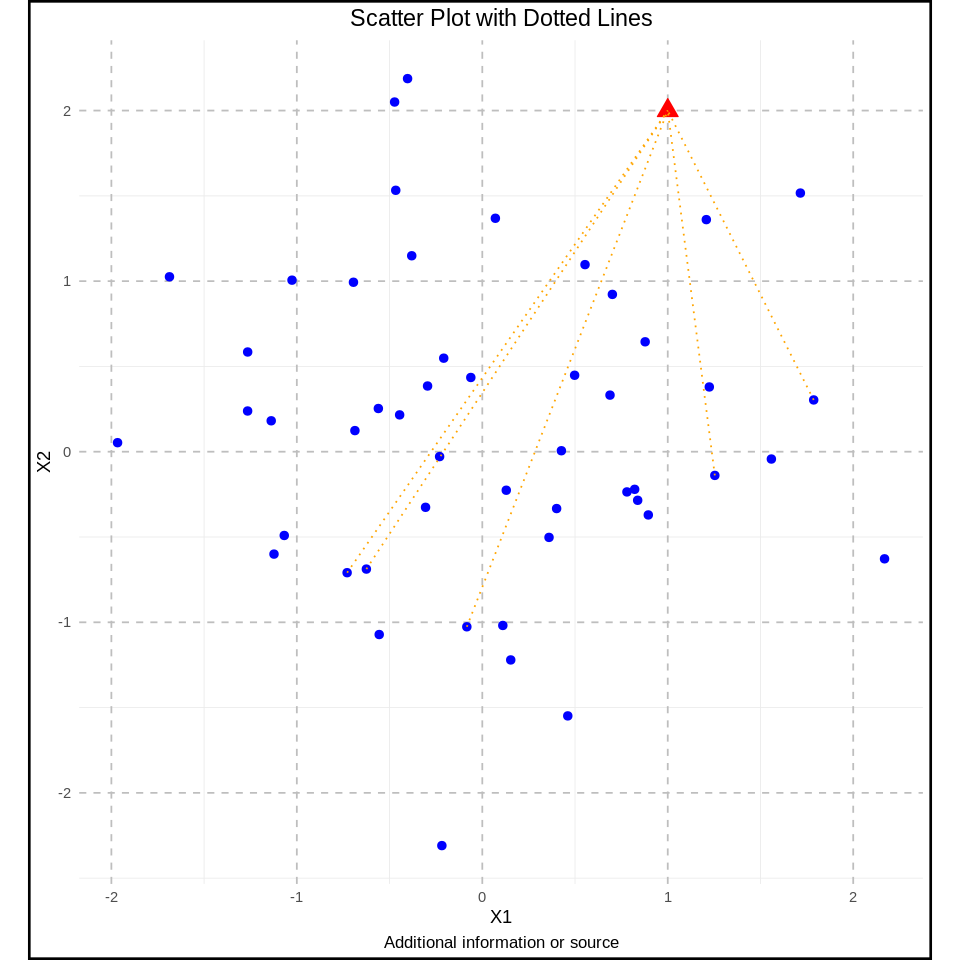

In [ ]:
library(ggplot2)
library(dplyr)

# Sample data
set.seed(123)
df <- data.frame(x1 = rnorm(50), x2 = rnorm(50))
d_star <- data.frame(x1 = 1, x2 = 2)  # Replace with your actual d_star values
n_points <- 5

# Scatter plot
scatter_plot <- ggplot(df, aes(x = x1, y = x2)) +
  geom_point(shape = 21, size = 2,fill="blue", color = "blue") +  # Circles for x1 vs x2
  geom_point(data = d_star, aes(x = x1, y = x2), shape = 24, size = 4,fill="red", color = "red") +  # Triangles for d_star geom_point(data = d_star, aes(x = x1, y = x2), shape = 24, size = 4, fill = "red", color = "red") +
  geom_segment(data = d_star, aes(x = x1, y = x2, xend = x1, yend = x2), color = "green", linetype = "dotted") +  # Dotted lines
  geom_segment(data = sample_n(df, n_points), aes(x = x1, y = x2, xend = d_star$x1, yend = d_star$x2), color = "orange", linetype = "dotted") +  # Dotted lines to n points

  # Customize appearance
  theme_minimal() +
  labs(
    title = "Scatter Plot with Dotted Lines",
    x = "X1",
    y = "X2",
    caption = "Additional information or source"
  ) +
  scale_shape_manual(values = c(21, 24)) +
  scale_color_manual(values = c("blue", "red", "green", "orange")) +
  theme(legend.position = "top",
        plot.title = element_text(size = 14, hjust = 0.5),
        plot.caption = element_text(size = 10, hjust = 0.5),
        plot.background = element_rect(size = 1.5, color = "black"),
        panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
        aspect.ratio = 1) +
  coord_fixed(ratio=1)

# Set the size of the entire plot
options(repr.plot.width=8, repr.plot.height=8)

# Print the plot
print(scatter_plot)


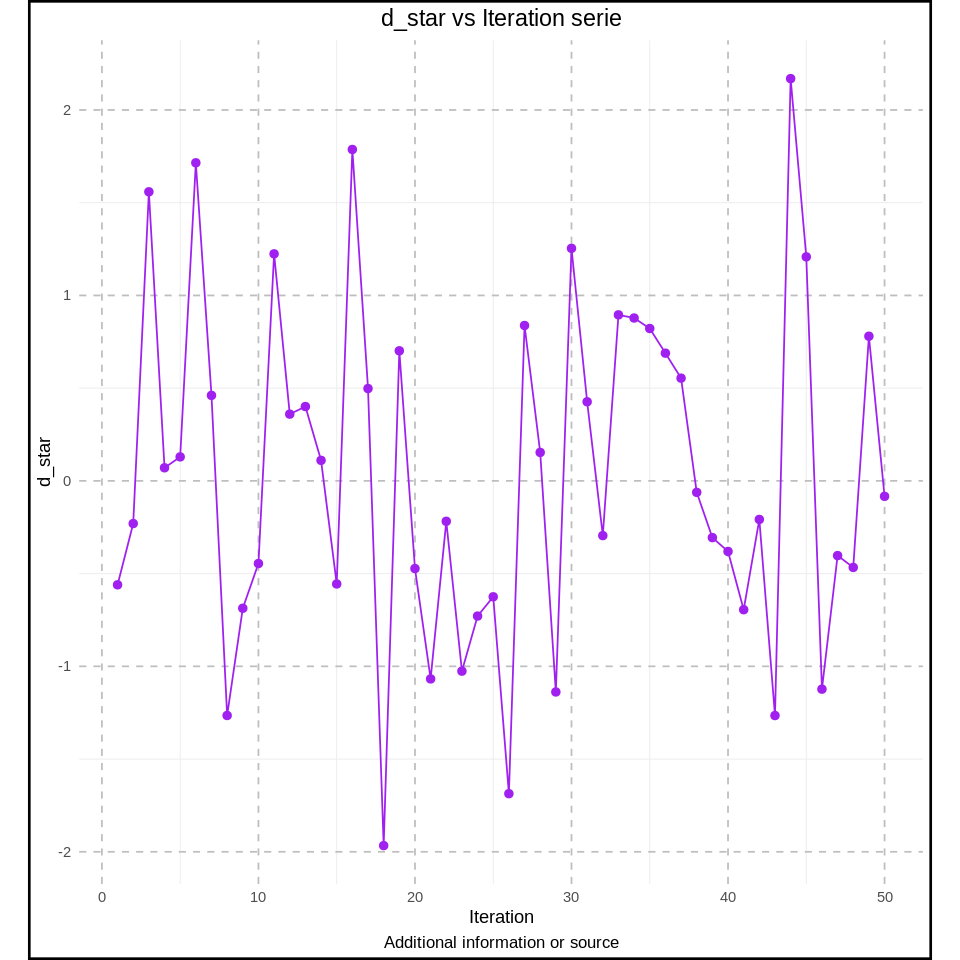

In [ ]:
library(ggplot2)

# Sample data
set.seed(123)
iterations <- 50
d_star_series <- data.frame(iteration = 1:iterations, d_star = rnorm(iterations))  # Replace with your actual d_star values

# Time series plot for d_star
time_series_plot <- ggplot(d_star_series, aes(x = iteration, y = d_star)) +
  geom_line(color = "purple") +  # Line connecting points
  geom_point(size = 2, color = "purple", fill = "purple") +  # Points
  theme_minimal() +
  labs(
    title = "d_star vs Iteration serie",
    x = "Iteration",
    y = "d_star",
    caption = "Additional information or source"
  ) +
  theme(legend.position = "none",
        plot.title = element_text(size = 14, hjust = 0.5),
        plot.caption = element_text(size = 10, hjust = 0.5),
        plot.background = element_rect(size = 1.5, color = "black"),
        panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
        aspect.ratio = 1) +
  coord_fixed(ratio=1)

# Set the size of the entire plot
options(repr.plot.width=8, repr.plot.height=8)

# Print the plot
print(time_series_plot)

In [ ]:
#Algorithm test
N=10000
n_c=20
n_d=1000
#true beta values
beta=c(-1,0.3,0.1)
#synthetic data
mu <- c(0, 0)
sigma <- matrix(c(3, 0, 0, 3), nrow = 2, ncol = 2)  # Covariance matrix
#sigma <- matrix(c(3, 1.5, 1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix positive
#sigma <- matrix(c(3, -1.5, -1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix negative
#getting the initial data
lista=data_gen_logit_2covars(N,sigma,mu,beta)
df=lista[[2]]
X=lista[[1]]
#Grid for the design
# Define the range and increment
x_range <- seq(-5, 5, by = 0.1)
y_range <- seq(-5, 5, by = 0.1)
grid_points <- expand.grid(x = x_range, y = y_range)
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]

fit=glm(y~x1+x2,family = "binomial",data=ds)
beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
O_fisher=vcov(fit) %>% solve()
  # Grid search and Expected information matrix for each point in grid search.
Imatrices=List_Infor_Matrices(grid_points,beta_est)
  # each expected information matrix must be sum it up with the O_fisher then for each resulting matrix compute the determinant then look for the data
Index_max_utility_val=Utility_func(Imatrices,O_fisher)
  #getting d_star
d_star=grid_points[Index_max_utility_val,]
l_top_df <- get_top_n_distances(df, d_star, n = 10)
#put the top points to the ds
df_2=l_top_df[[2]]
top_n_df_2=l_top_df[[1]]

ds=rbind(ds,top_n_df)
#}


In [ ]:
d_star %>% head()
top_n_df %>% head()

,x,y
,<dbl>,<dbl>
10174,2.3,5


,y,x1,x2,lp,p
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9866,1,2.388815,5.256711,0.2423155,0.5602842
5147,0,2.596238,4.635186,0.2423899,0.5603025
4165,0,2.339389,4.389616,0.1407783,0.5351366
4360,0,2.867582,4.691858,0.3294603,0.5816281
3777,0,2.534216,4.397757,0.2000406,0.5498440


Warning message:
“Removed 8608 rows containing missing values (`geom_point()`).”


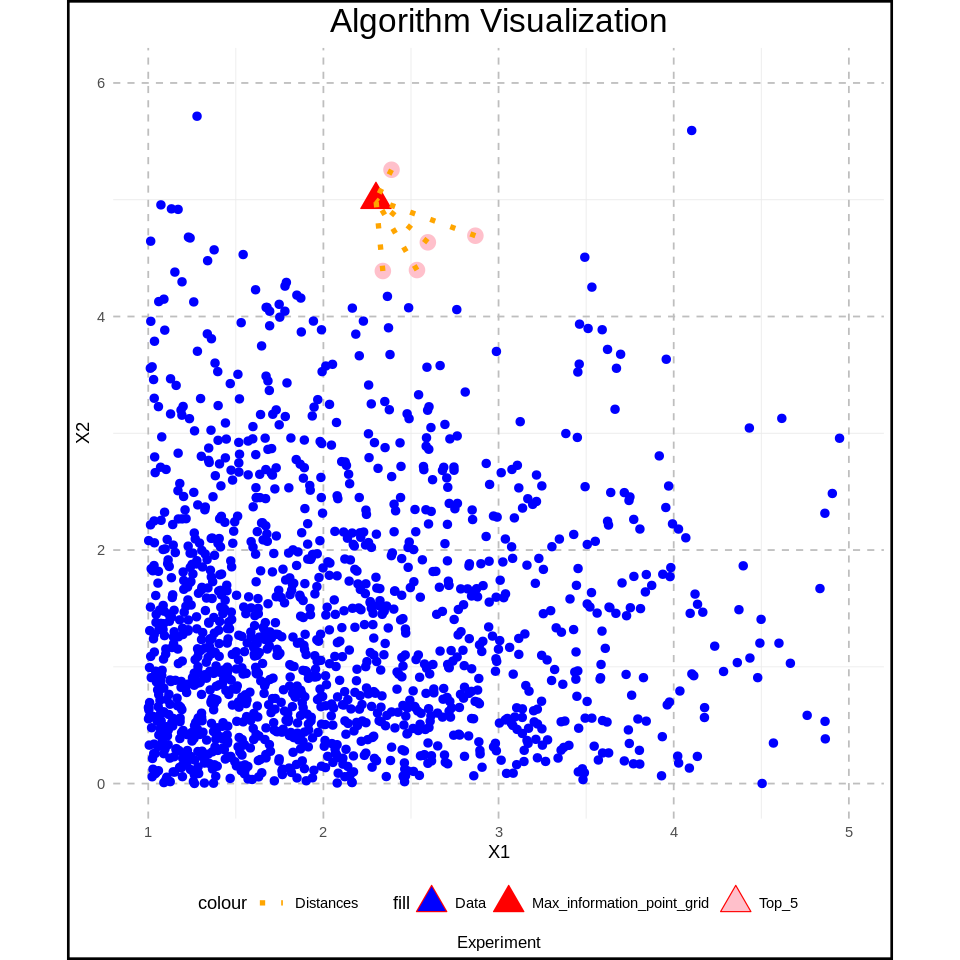

In [ ]:
#Paper algorithm
library(ggplot2)

scatter_plot <- ggplot(df, aes(x = x1, y = x2)) +
  geom_point(shape = 21, size = 2, aes(fill = "Data"), color = "blue") +  # Circles for x1 vs x2
  geom_point(data = top_n_df, aes(x = x1, y = x2, fill = "Top_5"), shape = 21, size = 4, color = "pink")  + #top 5 points
  geom_point(data = d_star, aes(x = x, y = y, fill = "Max_information_point_grid"), shape = 24, size = 6, color = "red") +  # Triangles for d_star
  #geom_segment(data = d_star, aes(x = x, y = y, xend = x, yend = y, color = "Custom Label 3"), linetype = "dotted") +  # Dotted lines
  geom_segment(data = top_n_df, aes(x = x1, y = x2, xend = d_star$x, yend = d_star$y, color = "Distances"), linetype = "dotted", linewidth = 1.5) +
  xlim(1, 5) +
  ylim(0, 6) +
  # Customize appearance
  theme_minimal() +
  labs(
    title = "Algorithm Visualization",
    x = "X1",
    y = "X2",
    caption = "Experiment"
  ) +
  scale_shape_manual(values = c(21, 21)) +
  scale_fill_manual(values = c("Data" = "blue", "Top_5" = "pink", "Max_information_point_grid" = "red")) +
  scale_color_manual(values = c( "Distances" = "orange")) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(size = 20, hjust = 0.5),
    plot.caption = element_text(size = 10, hjust = 0.5),
    plot.background = element_rect(size = 1.5, color = "black"),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    aspect.ratio = 1
  ) +
  coord_fixed(ratio = 1)

# Set the size of the entire plot
options(repr.plot.width = 8, repr.plot.height = 8)

# Print the plot
print(scatter_plot)



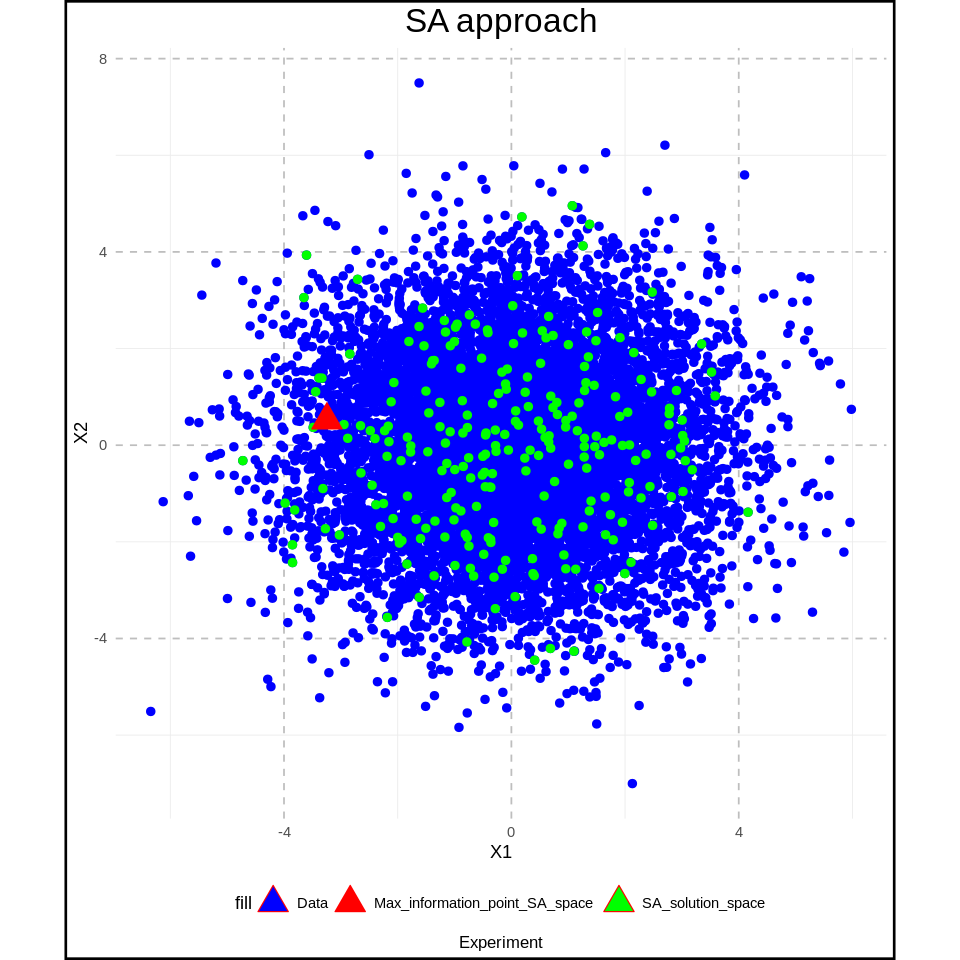

In [ ]:
#SA algorithm
library(ggplot2)
n_points=250
SA=sample_n(df, n_points)
scatter_plot <- ggplot(df, aes(x = x1, y = x2)) +
  geom_point(shape = 21, size = 2, aes(fill = "Data"), color = "blue") +  # Circles for x1 vs x2
  geom_point(data = SA, aes(x = x1, y = x2, fill = "SA_solution_space"), shape = 21, size = 2, color = "green")  + #top 5 points
  geom_point(data = sample_n(SA, 1), aes(x = x1, y = x2, fill = "Max_information_point_SA_space"), shape = 24, size = 6, color = "red") +  # Triangles for d_star
  #geom_segment(data = d_star, aes(x = x, y = y, xend = x, yend = y, color = "Custom Label 3"), linetype = "dotted") +  # Dotted lines
  #geom_segment(data = top_n_df, aes(x = x1, y = x2, xend = d_star$x, yend = d_star$y, color = "Distances"), linetype = "dotted", linewidth = 1.5) +
  #xlim(1, 5) +
  #ylim(0, 6) +
  # Customize appearance
  theme_minimal() +
  labs(
    title = "SA approach",
    x = "X1",
    y = "X2",
    caption = "Experiment"
  ) +
  scale_shape_manual(values = c(21, 21)) +
  scale_fill_manual(values = c("Data" = "blue", "SA_solution_space" = "green","Max_information_point_SA_space"="red")) +
  #scale_color_manual(values = c( "Distances" = "orange")) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(size = 20, hjust = 0.5),
    plot.caption = element_text(size = 10, hjust = 0.5),
    plot.background = element_rect(size = 1.5, color = "black"),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    aspect.ratio = 1
  ) +
  coord_fixed(ratio = 1)

# Set the size of the entire plot
options(repr.plot.width = 8, repr.plot.height = 8)

# Print the plot
print(scatter_plot)

Warning message:
“Removed 8608 rows containing missing values (`geom_point()`).”


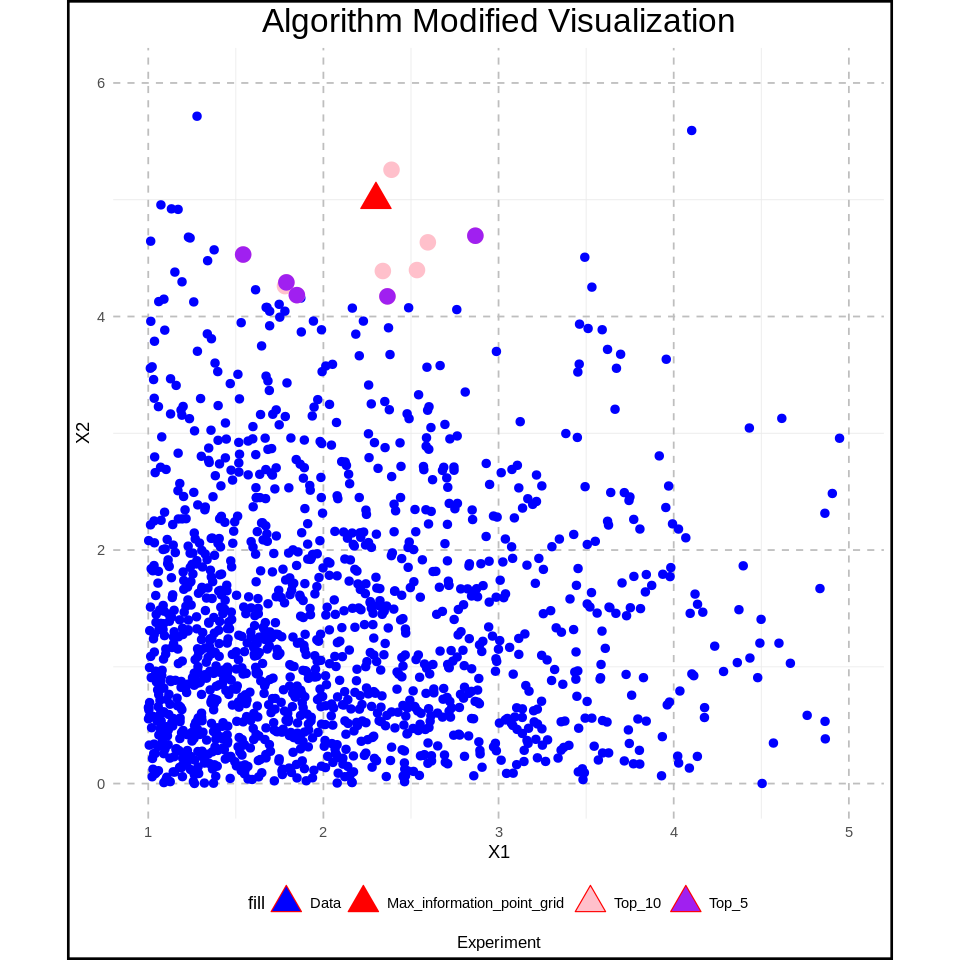

In [ ]:
#Paper modified algorithm
library(ggplot2)

scatter_plot <- ggplot(df, aes(x = x1, y = x2)) +
  geom_point(shape = 21, size = 2, aes(fill = "Data"), color = "blue") +  # Circles for x1 vs x2
  geom_point(data = top_n_df_2, aes(x = x1, y = x2, fill = "Top_10"), shape = 21, size = 4, color = "pink")  + #top 5 points
  geom_point(data = sample_n(top_n_df_2, 5), aes(x = x1, y = x2, fill = "Top_5"), shape = 21, size = 4, color = "purple")  + #top 5 points
  geom_point(data = d_star, aes(x = x, y = y, fill = "Max_information_point_grid"), shape = 24, size = 6, color = "red") +  # Triangles for d_star
  #geom_segment(data = d_star, aes(x = x, y = y, xend = x, yend = y, color = "Custom Label 3"), linetype = "dotted") +  # Dotted lines
  #geom_segment(data = top_n_df_2, aes(x = x1, y = x2, xend = d_star$x, yend = d_star$y, color = "Distances"), linetype = "dotted", linewidth = 1.5) +
  xlim(1, 5) +
  ylim(0, 6) +
  # Customize appearance
  theme_minimal() +
  labs(
    title = "Algorithm Modified Visualization",
    x = "X1",
    y = "X2",
    caption = "Experiment"
  ) +
  scale_shape_manual(values = c(21, 21)) +
  scale_fill_manual(values = c("Data" = "blue", "Top_10" = "pink","Top_5"="purple", "Max_information_point_grid" = "red")) +
  #scale_color_manual(values = c( "Distances" = "orange")) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(size = 20, hjust = 0.5),
    plot.caption = element_text(size = 10, hjust = 0.5),
    plot.background = element_rect(size = 1.5, color = "black"),
    panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
    aspect.ratio = 1
  ) +
  coord_fixed(ratio = 1)

# Set the size of the entire plot
options(repr.plot.width = 8, repr.plot.height = 8)

# Print the plot
print(scatter_plot)


In [ ]:
#Algorithm test
N=10000
n_c=20
n_d=1000
#true beta values
beta=c(-1,0.3,0.1)
#synthetic data
mu <- c(0, 0)
sigma <- matrix(c(3, 0, 0, 3), nrow = 2, ncol = 2)  # Covariance matrix
#sigma <- matrix(c(3, 1.5, 1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix positive
#sigma <- matrix(c(3, -1.5, -1.5, 3), nrow = 2, ncol = 2)  # Covariance matrix negative
#getting the initial data
lista=data_gen_logit_2covars(N,sigma,mu,beta)
df=lista[[2]]
X=lista[[1]]
#Grid for the design
# Define the range and increment
x_range <- seq(-5, 5, by = 0.1)
y_range <- seq(-5, 5, by = 0.1)
grid_points <- expand.grid(x = x_range, y = y_range) #Grid for the design
Data_ini=Sampling(n_c,0,df,X)
ds=Data_ini[[1]]
df=Data_ini[[2]]
X=Data_ini[[3]]
X_ds=Data_ini[[4]]

#Algorithm Concept Paper
iterations<- 1:1000
D_star= vector( "numeric" , 1000 )
i=1
while(nrow(ds)< n_d){
  #line 3 algorithm
  #estimation of parameters with ds
  fit=glm(y~x1+x2,family = "binomial",data=ds)
  beta_est=fit$coefficients
  #Observed information matrix for the model compute with ds, this for utility function
  O_fisher=vcov(fit) %>% solve()
  # Grid search and Expected information matrix for each point in grid search.
  Imatrices=List_Infor_Matrices(grid_points,beta_est)
  # each expected information matrix must be sum it up with the O_fisher then for each resulting matrix compute the determinant then look for the data
  Index_max_utility_val=Utility_func(Imatrices,O_fisher)
  D_star[i]=Index_max_utility_val
  i=i+1
  #getting d_star
  d_star=grid_points[Index_max_utility_val,]
  l_top_df <- get_top_n_distances(df, d_star, n = 20)
  #put the top points to the ds
  df=l_top_df[[2]]
  top_n_df=l_top_df[[1]]

  ds=rbind(ds,top_n_df)
}



In [ ]:
fit=glm(y~x1+x2,family = "binomial",data=ds)
fit$coefficients

(Intercept)          x1          x2 
 -0.9690378   0.2767283   0.1246133

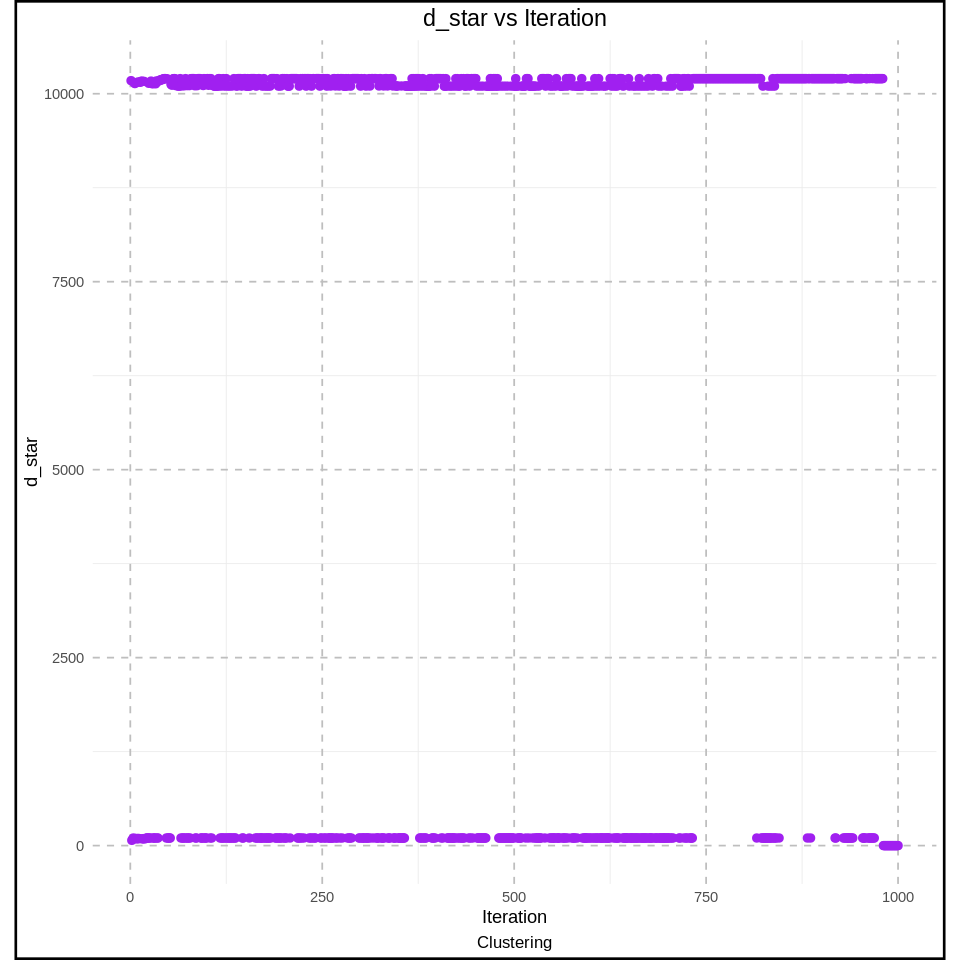

In [ ]:
d_star_series <- data.frame(iteration =iterations, d_star = D_star)  # Replace with your actual d_star values

# Time series plot for d_star
time_series_plot <- ggplot(d_star_series, aes(x = iteration, y = d_star)) +
  #geom_line(color = "purple") +  # Line connecting points
  geom_point(size = 2, color = "purple", fill = "purple") +  # Points
  theme_minimal() +
  labs(
    title = "d_star vs Iteration",
    x = "Iteration",
    y = "d_star",
    caption = "Clustering"
  ) +
    #xlim(-500,1300 ) +
    #ylim(-1000,1100) +
  theme(legend.position = "none",
        plot.title = element_text(size = 14, hjust = 0.5),
        plot.caption = element_text(size = 10, hjust = 0.5),
        plot.background = element_rect(size = 1.5, color = "black"),
        panel.grid.major = element_line(color = "gray", linetype = "dashed", size = 0.5),
        aspect.ratio = 1) +
  coord_fixed(ratio=1)

# Set the size of the entire plot
options(repr.plot.width=8, repr.plot.height=8)

# Print the plot
print(time_series_plot)